In [1]:
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
import audiosegment

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from tqdm import tqdm_notebook as tqdm

# for visualization later on
piano_img = os.path.join('assets', 'piano.jpg')

# dataframe to map notes, frequencies, and keyboard keys
freqs = pd.read_csv(os.path.join('assets', 'freqs.csv'))
freqs = freqs.iloc[1: ,:4]
freqs['Helmholtzname'] = freqs.Helmholtzname.apply(lambda x: x.replace('′', ''))
freqs['Helmholtzname'] = freqs.Helmholtzname.apply(lambda x: x.replace('͵', ''))
freqs['Helmholtzname'] = freqs.Helmholtzname.apply(lambda x: x.split(' ')[0])
freqs['Helmholtzname'] = freqs.Helmholtzname.apply(lambda x: x.upper())
freqs['Frequency (Hz)'] = freqs['Frequency (Hz)'].astype(np.float16)
freqs['Keynumber'] = freqs['Keynumber'].astype(np.uint8)
freqs = freqs[freqs.Keynumber <= 88]
freqs = freqs.sort_values('Keynumber', ascending=False)
freqs.index = range(1, 89)
freqs.head()

,Keynumber,Helmholtzname,Scientificname,Frequency (Hz)
1,88,C,C8 Eighth octave,4188.0
2,87,B,B7,3952.0
3,86,A♯/B♭,A♯7/B♭7,3730.0
4,85,A,A7,3520.0
5,84,G♯/A♭,G♯7/A♭7,3322.0


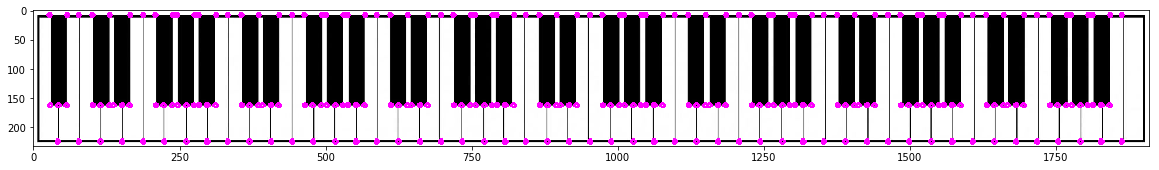

In [2]:
# generate keypoints of piano keys localized via `utils/localize_keyboard_mappings.py`

img = cv2.cvtColor(cv2.imread(piano_img), cv2.COLOR_BGR2RGB)
octave = 255

ab = np.array([[  8, 246], [162, 247], [162, 275], [  8, 276]])
a = np.array([[8, 276], [162, 275], [162, 262], [224, 262], [224, 298], [162, 297], [162, 283]])
bb = np.array([[8, 28], [162,  29], [162,  57], [8, 58]])
b = np.array([[8, 58], [162,  57], [162,  43], [224,  42], [224,  78], [8, 78]])
c = np.array([[8, 78], [224,  78], [224, 115], [162, 115], [162, 102], [8, 101]])
db = np.array([[8, 101], [162, 102], [162, 130], [8, 131]])
d = np.array([[8, 131], [162, 130], [162, 115], [224, 115], [224, 152], [162, 152], [162, 137]])
eb = np.array([[8, 131], [162, 137], [162, 165], [8, 166]])
e = np.array([[8, 166], [162, 165], [162, 152], [224, 152], [224, 188], [8, 188]])
f = np.array([[8, 188], [224, 188], [224, 224], [162, 223], [162, 210], [8, 209]])
gb = np.array([[8, 209], [162, 210], [162, 238], [8, 239]])
g = np.array([[8, 239], [162, 238], [162, 223], [224, 224], [224, 262], [162, 262], [162, 247], [8, 246]])

keys = {
    'bb': bb,
    'b': b,
    'c': c,
    'db': db,
    'd': d,
    'eb': eb,
    'e': e,
    'f': f,
    'gb': gb,
    'g': g,
    'ab': ab,
    'a': a, 
       }

j = 1
df = pd.DataFrame(columns=['note', 'points'])
for i in range(0, 8):
    for root, orig_key in keys.items():
        key = orig_key.copy()
        if root not in ['bb', 'b'] and i == 7:
            continue
        if i != 0:
            key[:, 1] = key[:, 1] + 255*i
        for p in key: 
            cv2.circle(img, tuple(p[::-1]), 3, [255, 0, 255], 4)
    
        df.loc[88-j] = [root+str(i), list(key)]
        j += 1
freqs = freqs.join(df)

plt.figure(figsize=(20, 3))
plt.imshow(img)
plt.show()

In [3]:
# # download a song
# # https://superuser.com/questions/1266162/youtube-dl-set-sample-rate-on-mp3
# !youtube-dl --extract-audio --audio-quality 0 --audio-format mp3 --postprocessor-args "-r 44100" https://www.youtube.com/watch?v=zE0Fwm7gv1c


In [4]:
class Song:

    def __init__(self, mp3_file):
        # music data
        self.seg = audiosegment.from_file(mp3_file)
        self.arr = np.array(self.seg.seg.get_array_of_samples())
                
        # key numbers
        self.in_sample_rate = self.seg.frame_rate
        self.num_samples = len(self.arr)
        self.ms = len(self.seg)
        self.bpm = self.get_bpm()
        self.num_beats = int(self.num_samples / self.bpm)
        self.max_freq = 4186 # hz of high c (key 88)
        
        def find_nearest(value):
            # quantize to nearest note, indexed by freqs df
            array = freqs['Frequency (Hz)']
            idx = (np.abs(array - value)).idxmin()
            return 89-idx
        self.get_notes = np.vectorize(find_nearest)


    def get_bpm(self):
#         https://gist.github.com/jiaaro/faa96fabd252b8552066
        low_seg = self.seg.low_pass_filter(120.0)
        # anything above average loudness
        beat_loudness = low_seg.dBFS 
        minimum_silence = int(60000 / 240.0) # max tempo
        nonsilent_times = detect_nonsilent(low_seg, minimum_silence, beat_loudness)

        spaces_between_beats = []
        last_t = nonsilent_times[0][0]

        for peak_start, _ in nonsilent_times[1:]:
            spaces_between_beats.append(peak_start - last_t)
            last_t = peak_start

        # base bpm guess on the median space between beats
        spaces_between_beats = sorted(spaces_between_beats)
        space = spaces_between_beats[len(spaces_between_beats) // 2]

        bpm = 60000 / space
        return bpm
    
    def get_1beat_fft(self, offset, plot=False):
        delta = int(self.ms / self.bpm) #ms

        hist_bins, hist_vals = self.seg[1+offset:delta+offset].fft()
        hist_vals_real_normed = np.abs(hist_vals) / len(hist_vals)

        thresh = hist_bins < self.max_freq
        bins = hist_bins[thresh]
        vals = hist_vals_real_normed[thresh]

        if plot:
            plt.plot(bins , vals)
            plt.xlabel("Hz"); plt.ylabel("dB")
            plt.show()

        return bins, vals
    
    def get_peaks(self, bins, vals, plot=False):
        peaks = argrelextrema(vals, np.greater, order=101)[0]
        hz_peaks, db_peaks = bins[peaks], vals[peaks]

        thresh = db_peaks > 1 # minimum decibels
        hz_peaks, db_peaks = hz_peaks[thresh], db_peaks[thresh]

        if plot:
            plt.figure(figsize=(16, 5))
            plt.plot(bins, vals)
            plt.scatter(hz_peaks, db_peaks, s=12, c='r')
            plt.title('FFT plot of sample')
            plt.xlabel("Hz"); plt.ylabel("dB")
            plt.show()

        return hz_peaks, db_peaks
    

    def sample(self, offset=0, plot=False):
        """
        Gerneate a sample of the song with metadata about frequency information. 
        Args: 
            offset (int): offset in ms from beginning of song
            plot (bool): whether to plot the FFT plot
        Returns:
            pd.DataFrame of sample metadata
        """
        dominant_freqs, dbs = self.get_peaks(*self.get_1beat_fft(offset=offset), plot=plot)
        if len(dominant_freqs) == 0:
            return pd.DataFrame(columns = ['note', 'f', 'db', 'num'])
        notes_index = self.get_notes(dominant_freqs)
        notes = freqs.loc[89-np.unique(notes_index)].Helmholtzname
        notes_out = pd.DataFrame([notes.values, dominant_freqs, dbs, notes_index]).T
        notes_out.columns = ['note', 'f', 'db', 'num']
        return notes_out

# -----------------------------------------
def generate_keyboard(sample_data, debug=False):
    """
    Iterate through notes found in sample and draw on keyboard image. 
    Intensity of color depends on loudness (decibels).
    
    Args:
        samle_data (pd.DataFrame): df generated by Song.sample()
    Returns: 
        np.array image of colorized piano
    
    """
    piano_template = cv2.cvtColor(cv2.imread(piano_img), cv2.COLOR_BGR2RGB)

    for note in range(sample_data.shape[0]):
        piano = piano_template.copy()
        note_metadata = sample_data.iloc[note]
        freq_map = freqs.iloc[int(note_metadata['num'])]
        if type(freq_map.points) is not list:
            continue
        points = np.array(freq_map.points, dtype=np.int32)
        cv2.fillPoly(piano, [points[:, ::-1]], [0, 255, 0])

        if debug:
            print(note_metadata, freq_map)
            for p in points: 
                cv2.circle(piano, tuple(p[::-1]), 3, [255, 0, 255], 4)

        intensity = note_metadata.db / sample_data.db.max()
        piano_template = cv2.addWeighted(piano_template, 1-intensity, piano, intensity, 0)
        
    return piano_template

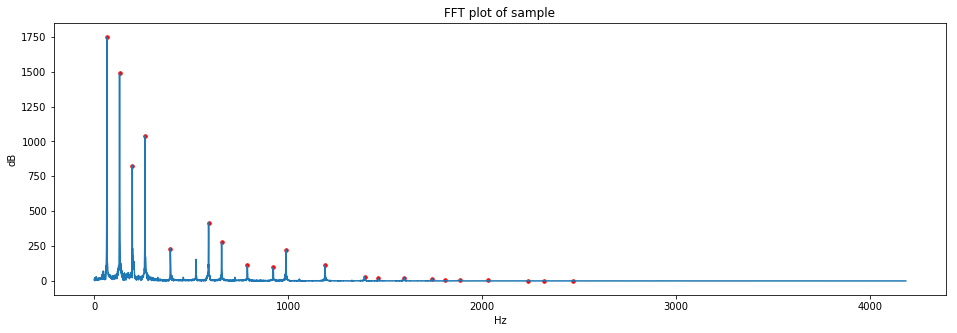

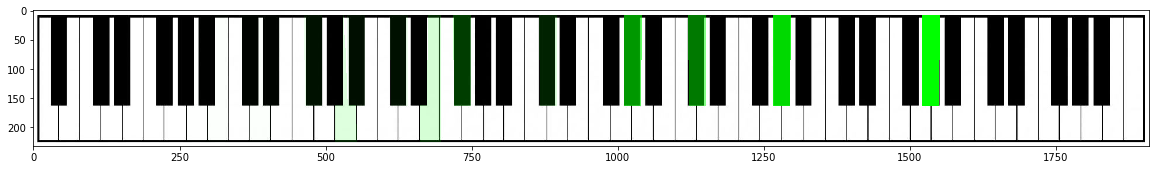

In [5]:
song_file = os.path.join('assets', 'twinkle.mp3')
s = Song(song_file)
sample_data = s.sample(5000, plot=True)
piano_lit = generate_keyboard(sample_data)

plt.figure(figsize=(20, 3))
plt.imshow(piano_lit)
plt.show()

In [6]:
frames = []
sample_rate = 50
for offset in tqdm(range(0, s.ms, sample_rate)):
    sample_data = s.sample(offset=offset)
    piano_lit = generate_keyboard(sample_data)
    frames.append(piano_lit)
    
from moviepy.editor import *
clips = [ImageClip(f).set_duration(sample_rate/1000.) for f in frames]
concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip = concat_clip.set_audio(AudioFileClip(song_file))
concat_clip.write_videofile("test.mp4", fps=1000//sample_rate,
                             temp_audiofile="temp-audio.m4a", remove_temp=True,
                             codec="libx264", audio_codec="aac")
!open test.mp4


[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing audio in temp-audio.m4a


100%|█████████████████████████████████████████████████████████████| 1047/1047 [00:01<00:00, 613.10it/s]


[MoviePy] Done.
[MoviePy] Writing video test.mp4


100%|████████████████████████████████████████████████████████████████| 949/949 [00:15<00:00, 59.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



'open' is not recognized as an internal or external command,
operable program or batch file.
